<a href="https://colab.research.google.com/github/british2002/tsml-18/blob/main/%D0%94%D0%97_%D0%AD%D0%BB%D0%B5%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%80%D0%BD%D1%8B%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

1.   Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
2.   Приблизьте оба варианта моделями из класса MA.
3.   Оцените качество и пришлите соображения, почему была выбрана та или иная модель.





# Часть 0. Подготовка данных

In [1]:
#импортируем пакеты для дальнейшей работы
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [2]:
#загружаем данные для анализа и работы
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [3]:
#определим функцию Дики-Фуллера
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
#определим функцию построения графиков (оригинал, автокорреляция, парной автокорреляции)
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

# Часть 1. Анализ нестационарного ряда "Международные перелеты"


Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


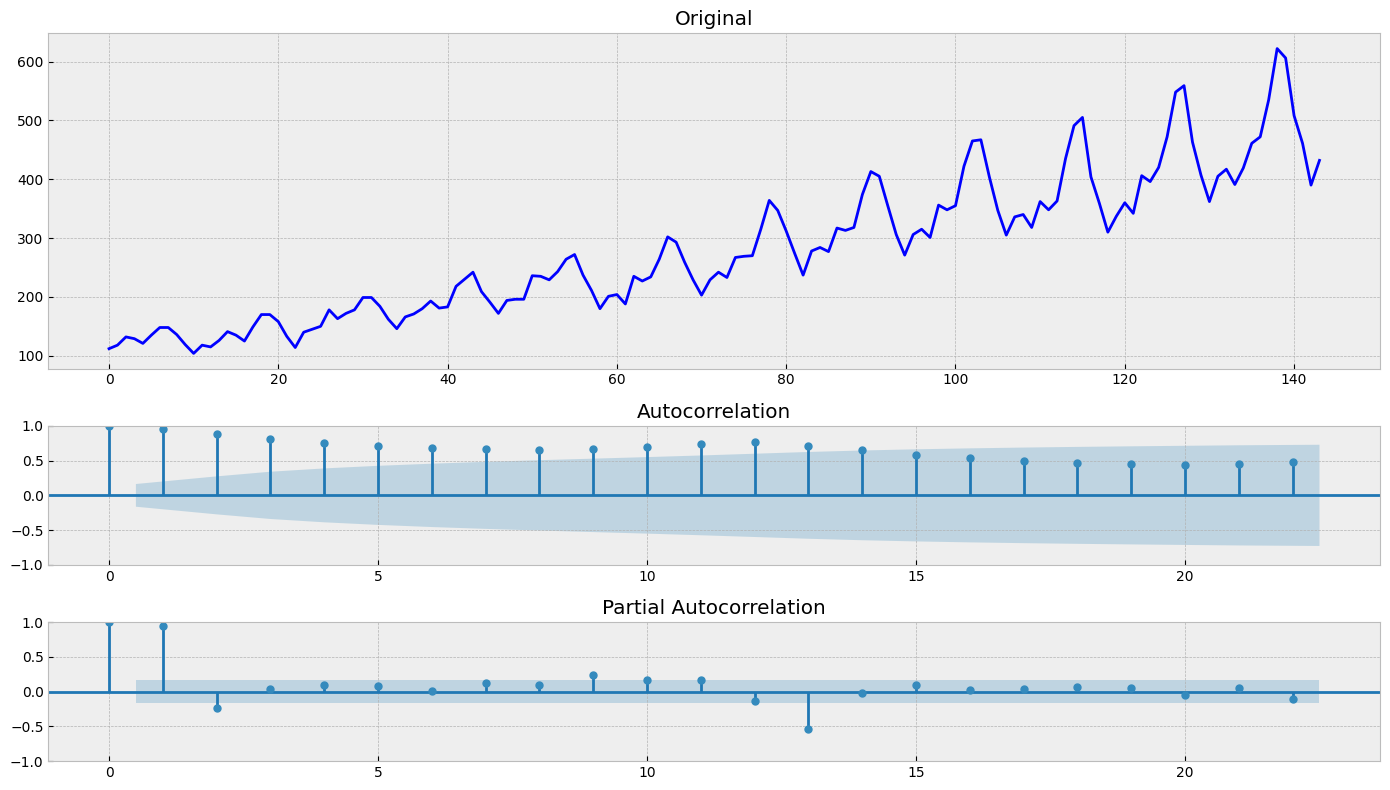

In [5]:
#проанализируем данные в international-airline-passengers.csv
series = airlines_passengers['Count']
tsplot(series)

In [6]:
#функция среднего скользящего Moving Average
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

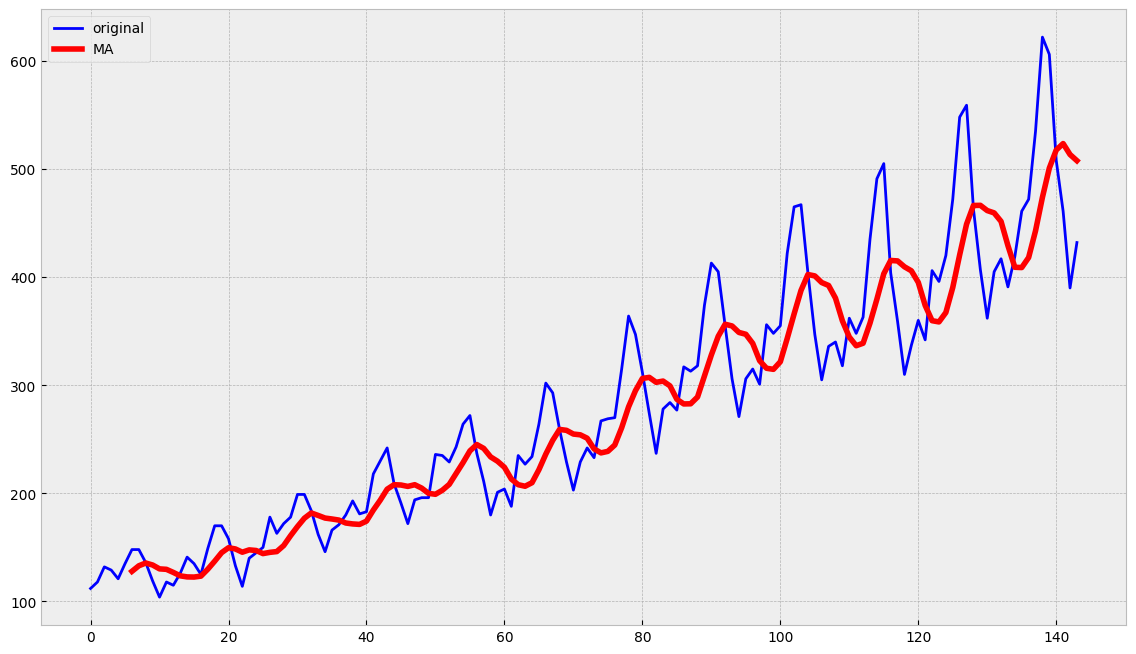

In [7]:
#применим MA к выбранному нестационарному графику
ma = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='4', label='MA')
    plt.legend()

In [8]:
#определим функцию взвешенного среднего скользящего Weighted Moving Average
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

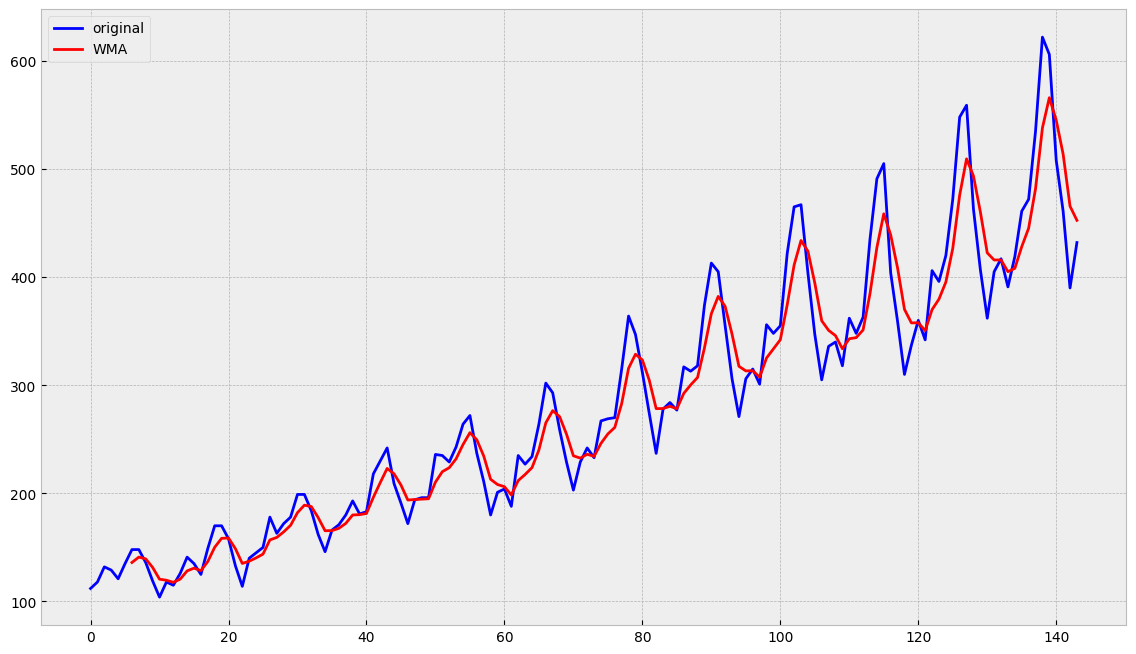

In [9]:
#применим WMA к выбранному нестационарному графику
wma = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(wma, color='red', linewidth='2', label='WMA')
    plt.legend()

In [10]:
#определим функцию экспоненциального среднего скользящего Exponetial Moving Average
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

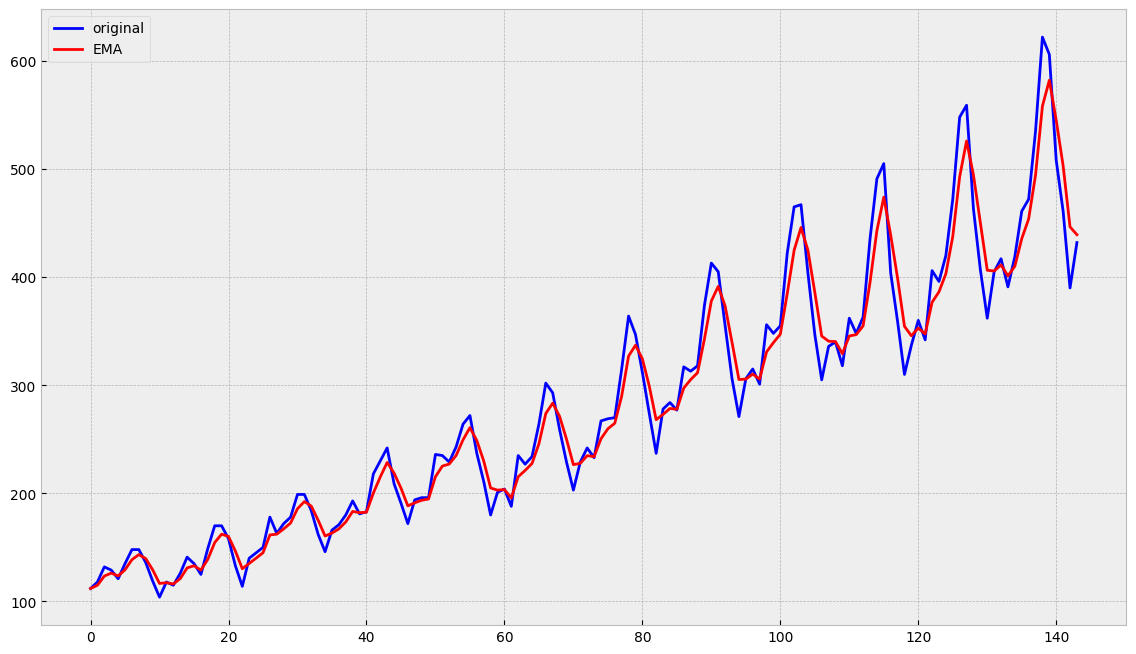

In [11]:
#применим EMA c коэффициентом 0.5 к выбранному нестационарному графику
ema = exponential_moving_average(series, 0.5)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ema, color='red', linewidth='2', label='EMA')
    plt.legend()

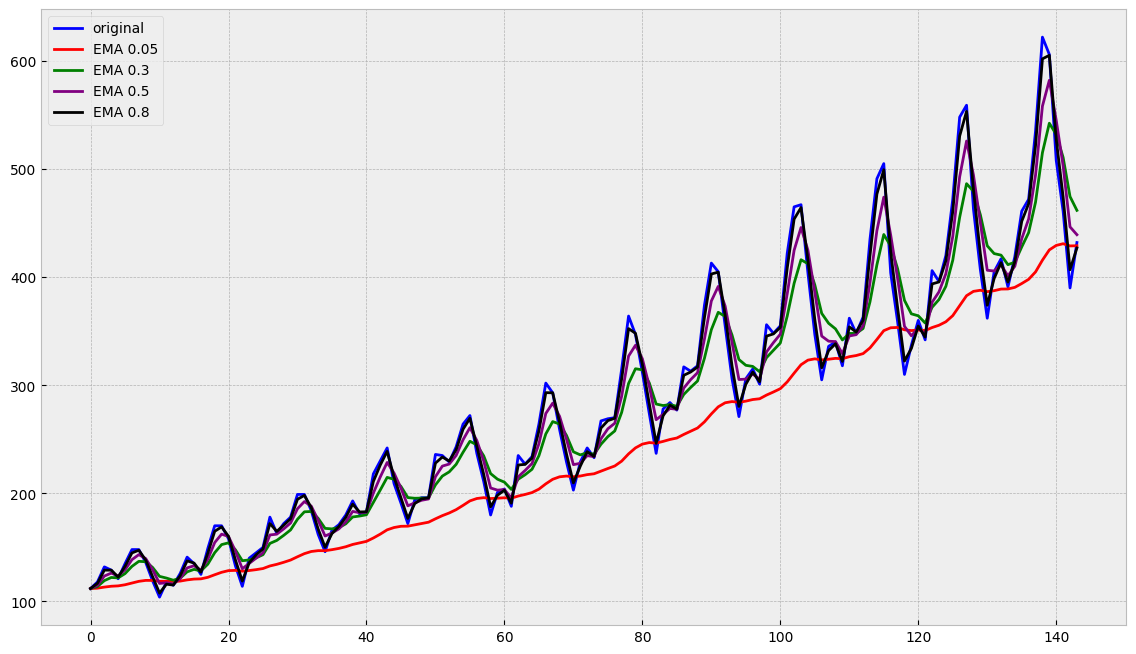

In [12]:
#определим подходящую альфу для EMA
alphas = [0.05,0.3,0.5,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(series, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

**Промежуточный вывод:** визуально больше подходит альфа == 0.8 для EMA

In [13]:
#определим "инициирующий тренд"
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [14]:
#определим инициирующие компоненты
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [15]:
#определим функцию TEMA
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [16]:
#определим функцию для визуализации результата
def plot_tema(alpha, beta, gamma, ser=series, ser_to_plot=series, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

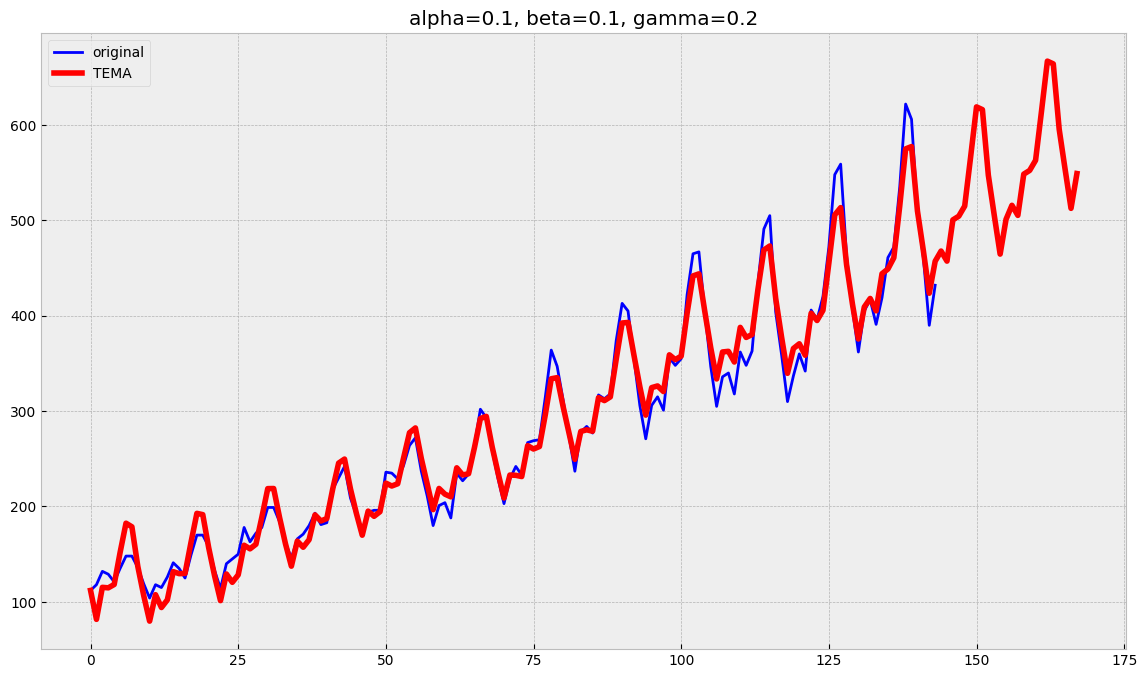

In [17]:
#нарисуем графики для коэф-в 0.1,0.1,0.2
plot_tema(0.1, 0.1, 0.2)

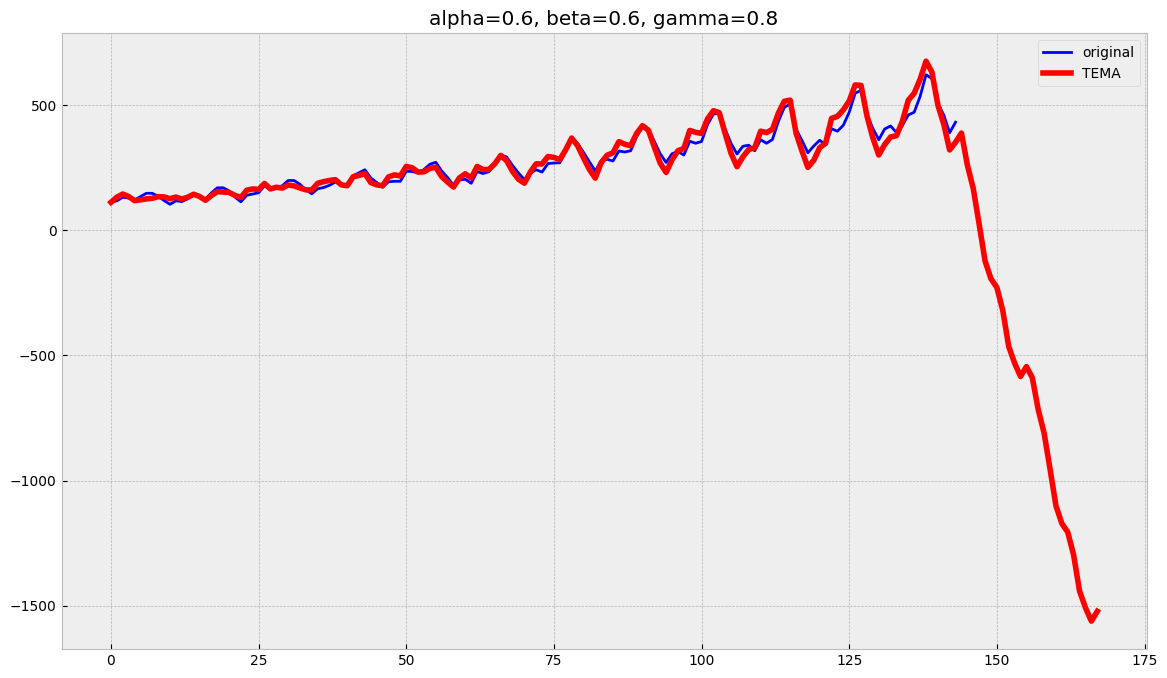

In [18]:
#нарисуем графики для коэф-в 0.6,0.6,0.8
plot_tema(0.6, 0.6, 0.8)

**Промежуточный вывод:** визуально больше подходит альфа == 0.1, бетта == 0.1, гамма == 0.2 для TEMA

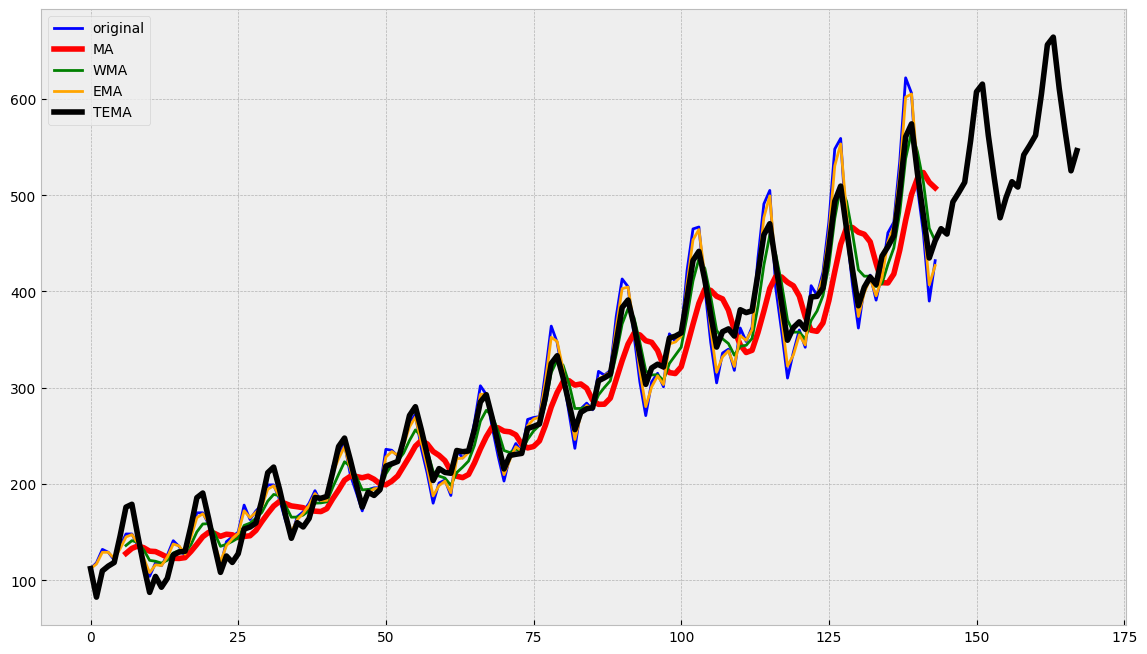

In [19]:
#создадим результирующий график
ema = exponential_moving_average(series, 0.8)
tema = triple_exponential_smoothing(ser, 12, 0.1, 0.1, 0.2, 24)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='4', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='orange', linewidth='2', label='EMA')
    plt.plot(tema, color='black', linewidth='4', label='TEMA')

    plt.legend()

# Часть 2. Анализ стационарного ряда "Ежедневные новорожденные девочки в Калифорнии"


Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


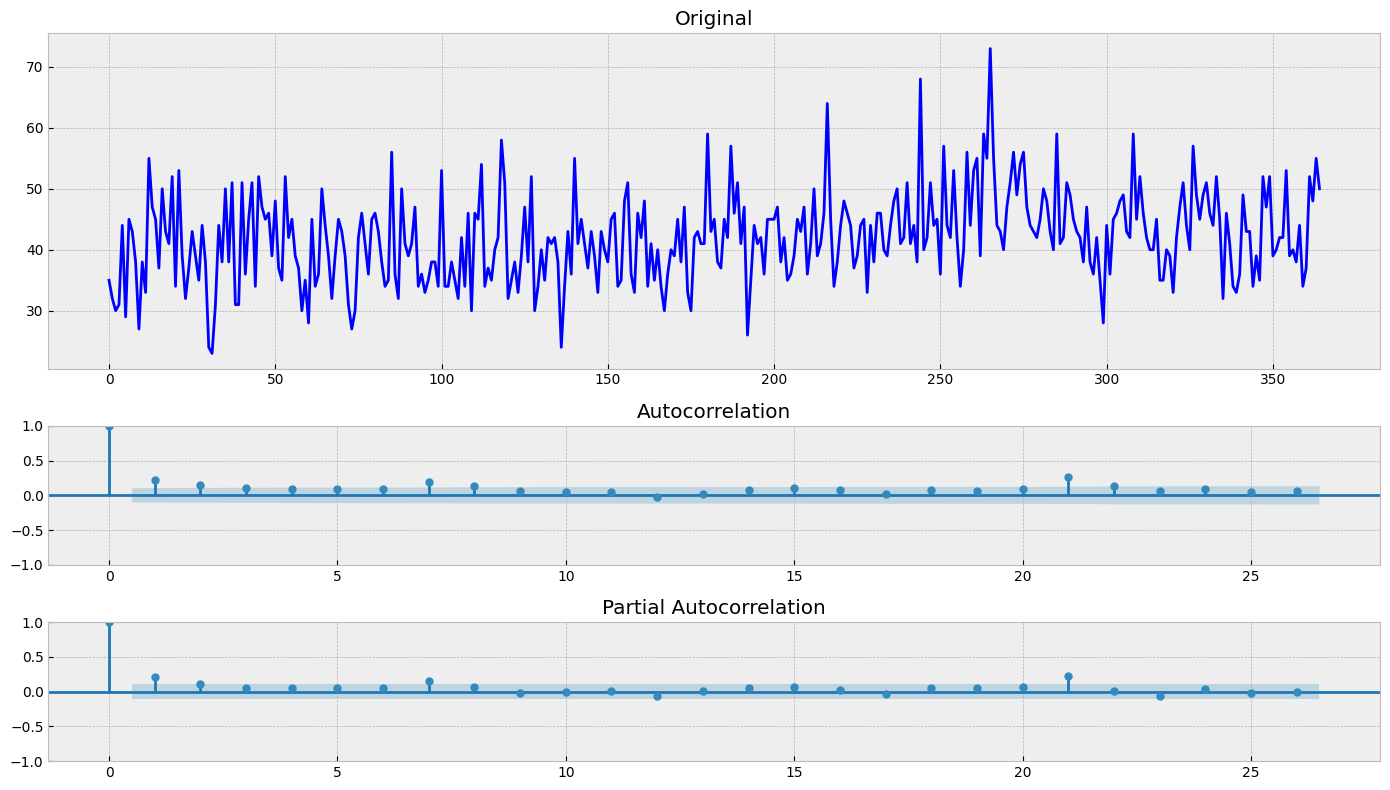

In [20]:
#проанализируем данные в  daily-total-female-births-in-cal.csv
series = female_births['Count']
tsplot(series)

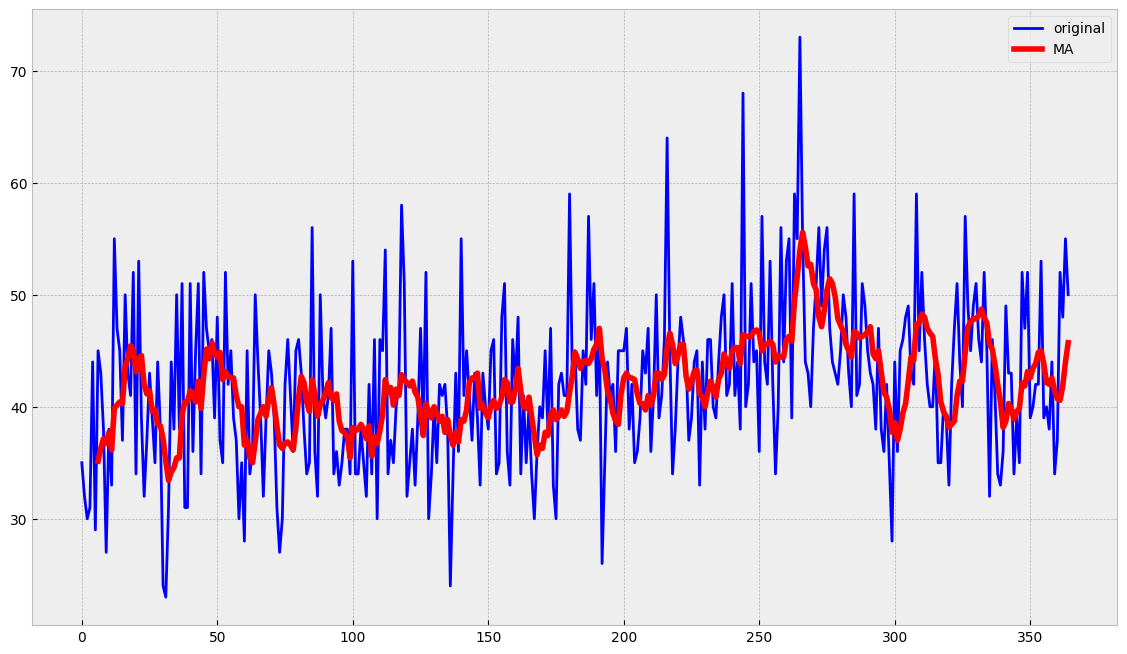

In [21]:
#применим MA к выбранному нестационарному графику
ma = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='4', label='MA')
    plt.legend()

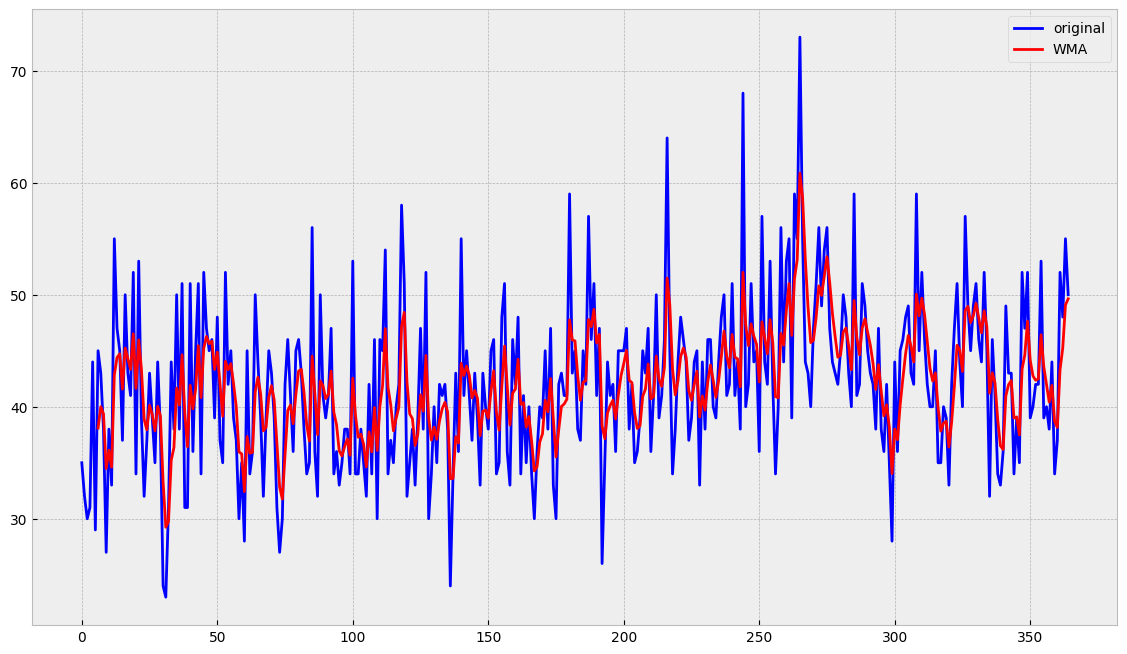

In [22]:
#применим WMA к выбранному нестационарному графику
wma = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(wma, color='red', linewidth='2', label='WMA')
    plt.legend()

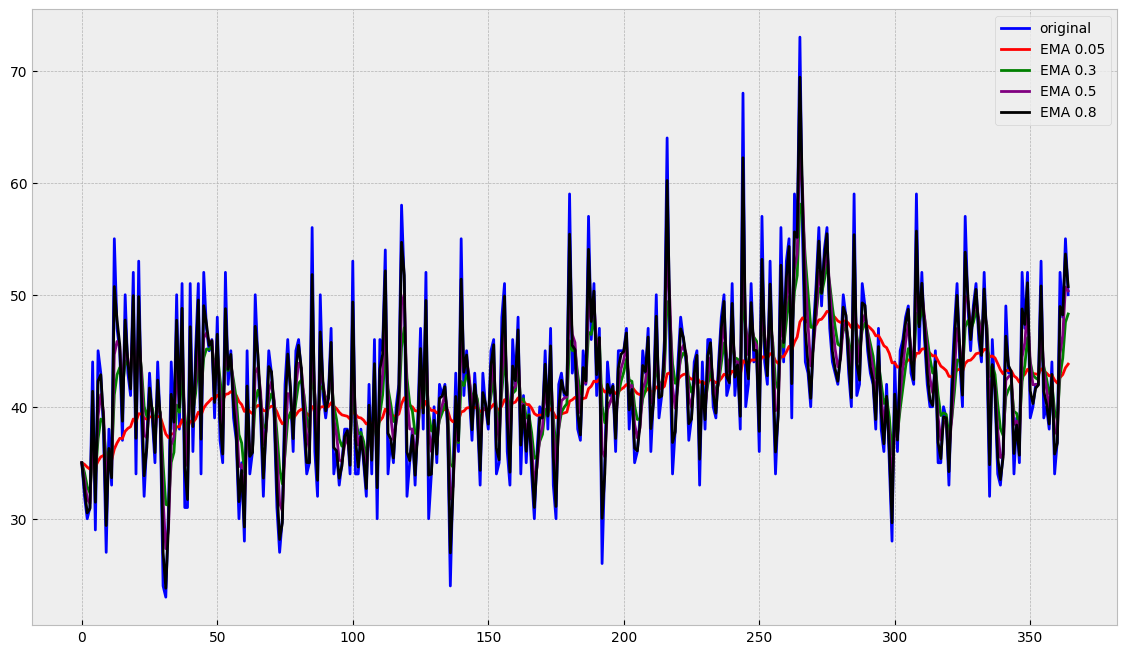

In [23]:
#определим подходящую альфу для EMA
alphas = [0.05,0.3,0.5,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(series, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

**Промежуточный вывод:** визуально больше подходит альфа == 0.8 для EMA

In [24]:
#попробуем подобрать параметры для ТЕМА автоматически
#определим длину массива данных
len(series)

365

In [25]:
#разобъем выборку на примерно равные части
train, test, val = ser[:125], ser[125:250], ser[250:]

In [26]:
#определим функцию среднеквадратичной ошибки
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [27]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [28]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 41.28058691934885
        x: [ 0.000e+00  0.000e+00  0.000e+00]
      nit: 0
      jac: [ 1.037e+03  0.000e+00  8.060e+01]
     nfev: 4
     njev: 1
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


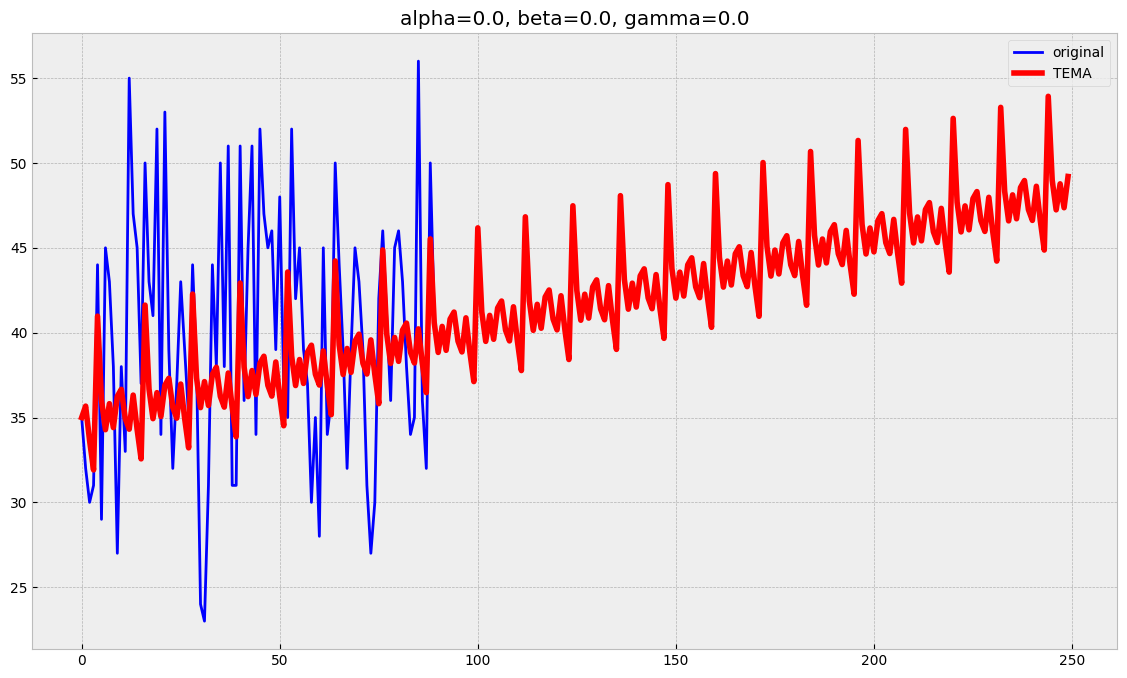

In [29]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:90], n_preds=len(test))

# Часть 3. Выводы
В итоге проведенных действий и визуального анализа результатов, можно сделать вывод, что наиболее подходяжим как для стационарного, так и для нестационарного рядов является экспоненциальное сглаживание с коэффициентом а==0.8.
Для прогнозирования как нестационарного, так и стационарных рядов лучше применять тройное сглаживание (методики Хольт-Винтерс).